In [1]:
cd ..

/Users/n.barsukov/PycharmProjects/toxic-comments-detector


In [2]:
import sys
import tensorflow as tf
import numpy as np

# local (this repo) imports
from dev import (
    load_cleaned_russian_text_data,
    get_class_weights,
    get_initial_output_bias,
    evaluate_model,
    SEED,
    VALIDATION_SPLIT_PARTITION,
    DEFAULT_BATCH_SIZE,
    DEFAULT_EPOCHS
)
from wordEmbeddingsLayers import create_multiBERT_preprocess_layer, create_multiBERT_encoder_layer

tf.random.set_seed(SEED)

print('Python version:', sys.version)
print('Tensorflow version:', tf.__version__)

Python version: 3.8.9 (default, Apr  3 2021, 01:50:09) 
[Clang 12.0.0 (clang-1200.0.32.29)]
Tensorflow version: 2.4.1


# Build RNN model

In [3]:
X_train, X_test, y_train, y_test = load_cleaned_russian_text_data()

In [4]:
from tensorflow.keras import layers
from typing import List

class BERTLayer(layers.Layer):
    def __init__(self, to_sequence = True):
        super(BERTLayer, self).__init__()
        self.to_sequence = to_sequence
        self.preprocessor = create_multiBERT_preprocess_layer()
        self.encoder = create_multiBERT_encoder_layer()

    def call(self, texts_arr: List[str]) -> tf.Tensor:
        preprocessed_texts = self.preprocessor(texts_arr)
        encoded_output = self.encoder(preprocessed_texts)
        
        return encoded_output['sequence_output'] if self.to_sequence else encoded_output['pooled_output']


In [5]:
from tensorflow.keras import layers, losses

negative_class_amount, pos_class_amount = np.bincount(y_train)

initial_output_bias = tf.keras.initializers.Constant(
    get_initial_output_bias(pos_class_amount, negative_class_amount)
)

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    mode='min',
    patience=2,
    verbose=1,
    restore_best_weights=False
)

model = tf.keras.Sequential([
    layers.Input(shape=[], dtype=tf.string),
    BERTLayer(to_sequence=True),
    
    layers.Bidirectional(tf.keras.layers.LSTM(256)),
    
    layers.Dense(128, activation='relu'),
    layers.Dropout(rate=0.5, seed=SEED),
    layers.Dense(units=1, bias_initializer=initial_output_bias),
    layers.Activation('sigmoid') # то есть в конце мы выдаем уже вероятности
])


# def build_classifier_model():
#     text_input = layers.Input(shape=[], dtype=tf.string, name='text')
    
#     # bert
#     preprocessing_layer = create_multiBERT_preprocess_layer()
#     encoder_inputs = preprocessing_layer(text_input)
#     encoder = create_multiBERT_encoder_layer()
#     outputs = encoder(encoder_inputs)
#     net = outputs['sequence_output']
    
#     # RNN
#     net = layers.Bidirectional(tf.keras.layers.LSTM(256))(net)
    
#     # fully connected and final
#     net = layers.Dense(128, activation='relu')(net)
#     net = layers.Dropout(rate=0.5, seed=SEED)(net)
#     net = layers.Dense(units=1, bias_initializer=initial_output_bias)(net)
#     net = layers.Activation('sigmoid')(net)
    
#     return tf.keras.Model(text_input, net)
    
# model = build_classifier_model()

model.compile(
    loss=losses.BinaryCrossentropy(from_logits=False), # from_logits=False, т.к. на выходе layers.Activation('sigmoid')
    optimizer='adam',
    metrics=[tf.keras.metrics.BinaryAccuracy(), tf.keras.metrics.Recall(), tf.keras.metrics.Precision()]
)

In [6]:
history = model.fit(
    x=X_train,
    y=y_train,
    epochs=1 or DEFAULT_EPOCHS,
    batch_size=DEFAULT_BATCH_SIZE // 8,
    validation_split=VALIDATION_SPLIT_PARTITION,
    callbacks=[early_stopping],
    class_weight=get_class_weights(pos_class_amount, negative_class_amount),
)

145/145 [==============================] - 3537s 24s/step - loss: 0.7654 - binary_accuracy: 0.5182 - recall: 0.4401 - precision: 0.3492 - val_loss: 0.6786 - val_binary_accuracy: 0.6670 - val_recall: 0.0000e+00 - val_precision: 0.0000e+00


# Model evaluation

Accuracy: 66.91%
Recall: 0.0%
Precision: 0.0%
F1-score: 0.0% 



/usr/local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


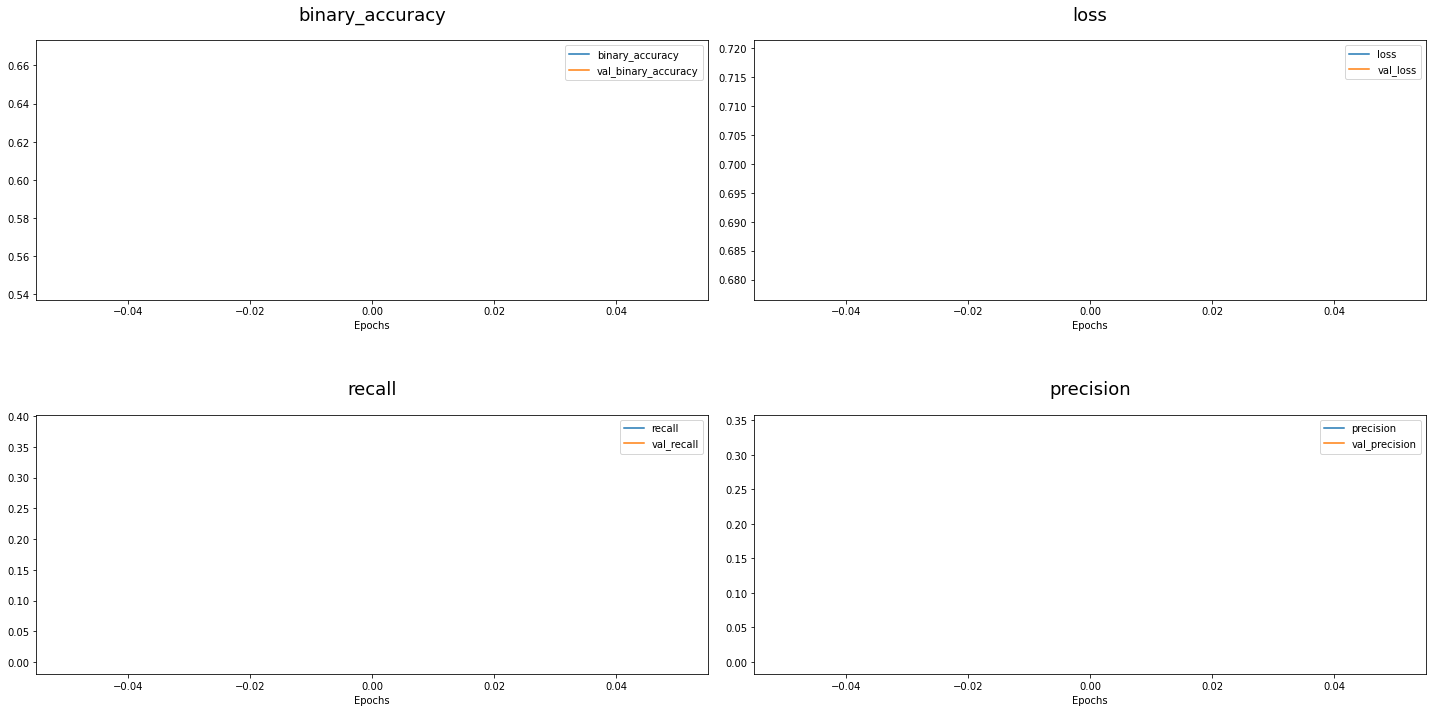

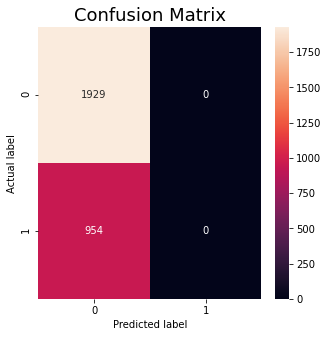

In [7]:
y_test_pred = (model.predict(X_test).flatten() > 0.5) * 1

evaluate_model(y_test, y_test_pred, history)